# Hist

```warning
The hist package is still under active development, the usage and contents are in flux.
```

Hist is the general class in the hist package based on [boost-histogram](https://github.com/scikit-hep/boost-histogram)'s Histogram. It supports the whole workflow for a histogram's lifecycle, including some plotting tools and shortcuts which are pretty useful for HEP studies. Here, you can see how to serialize/deserialize (*will be achieved*), construct, use, and visualize histograms via Hist.

![histogram's lifecycle](https://tva1.sinaimg.cn/large/007S8ZIlgy1ggrgi6xk7fj30y108qjsf.jpg)

## Initialize Hist

You need to initialized Hist first before you use it. Two ways are provided: you can just fill the axes into the Hist instance and create it; you can also add axes in Hist object via hist proxy. 

When initializing ou don't have to use named-axes, axes without names are allowed. But once you decide to use the names, you need to provide the valid Python identifiers as names without "\_" prefix. Using named-axes is recommended, because you will get more shortcuts to make the best of hist (there is also a classed called NamedHist which focuses on shortcuts with names). Duplicated names are not allowed in the Hist as name is the unique indentifier for a Hist object.

In [1]:
import hist

In [2]:
# fill the axes
h = hist.Hist(
    hist.axis.Regular(50, -4, 4, name="S", title="s [units]", underflow=False, overflow=False),
    hist.axis.Regular(50, -4, 4, name="W", title="w [units]", underflow=False, overflow=False)
)

In [3]:
# add the axes
h = hist.Hist.Reg(
    50, -4, 4, name="S", title="s [units]", underflow=False, overflow=False
).Reg(50, -4, 4, name="W", title="w [units]", underflow=False, overflow=False)

Note that you cannot add axes after you have initialized the Hist.

In [4]:
# add the axes to a existing histogram
h = hist.Hist(
    hist.axis.Regular(50, -4, 4, name="S", title="s [units]", underflow=False, overflow=False)
).Reg(50, -4, 4, name="W", title="w [units]", underflow=False, overflow=False)

RuntimeError: Cannot add an axis to an existing histogram

## Manipulate Hist

### Fill Hist

After initializing the Hist, the most likely thing you want to do is to fill it. The normal method to fill the histogram is just to pass the data to `.fill()`, and the data will be filled in the index order. If you have axes all with names in your Hist, you will have another option -- filling by names in the order of names given.

In [5]:
import numpy as np

s_data = np.random.normal(size=50_000)
w_data = np.random.normal(size=50_000)

# normal fill
h.fill(s_data, w_data)

# fill by names
h.fill(W=w_data, S=s_data)

Hist(
  Regular(50, -4, 4, underflow=False, overflow=False, metadata={'name': 'S', 'title': 's [units]'}),
  Regular(50, -4, 4, underflow=False, overflow=False, metadata={'name': 'W', 'title': 'w [units]'}),
  storage=Double()) # Sum: 99986.0

## Plot Hist

One of the most amazing feature of Hist is it's powerful plotting family. According to the different feature (dimension) of the histograms, Hist supports the following visualizing methods.

### Via Matplotlib

hist allows you to plot via [Matplotlib](https://matplotlib.org/) like this:

In [6]:
import matplotlib.pyplot as plt

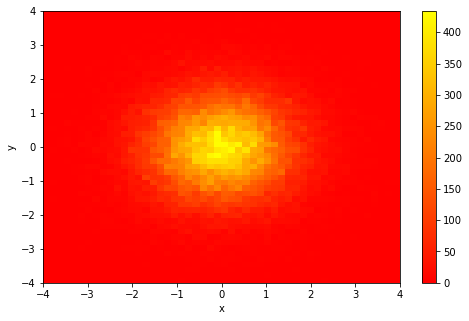

In [7]:
fig, ax = plt.subplots(figsize=(8,5))
w, x, y = h.to_numpy()
mesh = ax.pcolormesh(x, y, w.T, cmap='autumn')
ax.set_xlabel('x')
ax.set_ylabel('y')
fig.colorbar(mesh)
plt.show()

### Via Plot

Hist has plotting methods for 1-D and 2-D histograms, `.plot1d()` and `.plot2d()` respectively. It also provides `.plot()` for plotting according to the its dimension. Moreover, to show the projection of each axis, you can use `.plot2d_full()`. If you have a Hist with higher dimension, you can use `.project()` to extract two dimensions to see it with our plotting suite.

Our plotting methods are all based on Matplotlib, so you can pass Matplotlib's `fig` and `ax` into it, and hist will draw on them. We will create them for you, if you do not pass them in.

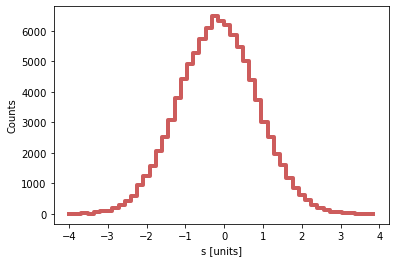

In [8]:
# plot1d
fig = plt.figure(figsize=(6, 4))
grid = fig.add_gridspec(5, 5, hspace=0, wspace=0)

ax = fig.add_subplot(grid[:, :])

fig, ax = h.project("S").plot1d(fig, ax, ls='-', c="indianred", lw=4)
plt.show()

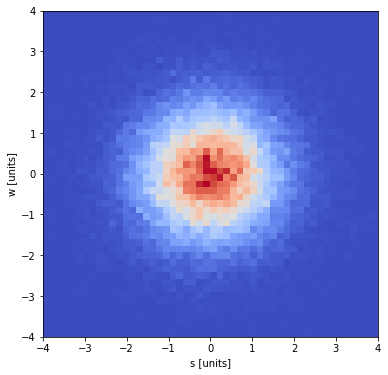

In [9]:
# plot2d
fig = plt.figure(figsize=(6, 6))
grid = fig.add_gridspec(5, 5, hspace=0, wspace=0)

ax = fig.add_subplot(grid[:, :])

fig, ax = h.plot2d(fig, ax, cmap="coolwarm")
plt.show()

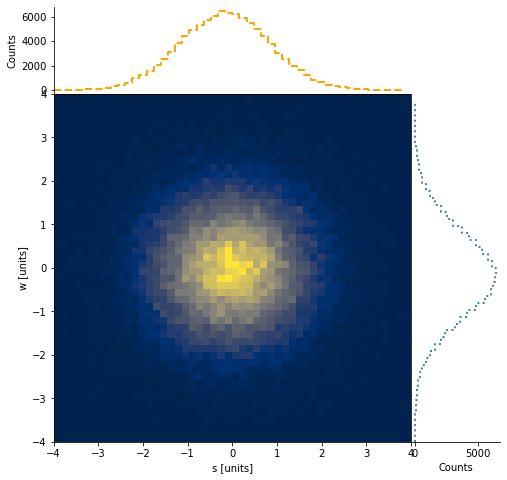

In [10]:
# plot2d_full
fig = plt.figure(figsize=(8, 8))
grid = fig.add_gridspec(5, 5, hspace=0, wspace=0)

main_ax = fig.add_subplot(grid[1:5, 0:4])
top_ax = fig.add_subplot(grid[0:1, 0:4], sharex=main_ax)
side_ax = fig.add_subplot(grid[1:5, 4:5], sharey=main_ax)

fig, main_ax, top_ax, side_ax = h.plot2d_full(fig, main_ax, top_ax, side_ax,\
                                              main_cmap="cividis", top_ls="--",\
                                              top_color="orange", top_lw=2, side_ls=":",\
                                              side_lw=2, side_color="steelblue"
                                             )

plt.show()

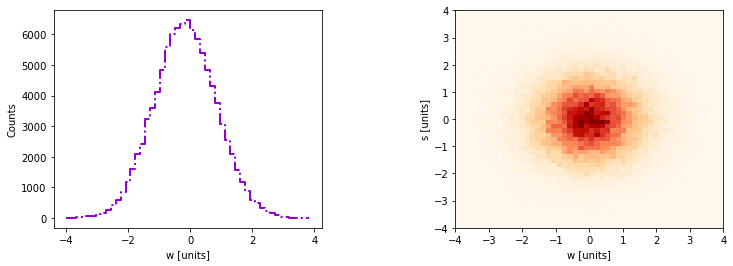

In [11]:
# auto-plot
fig = plt.figure(figsize=(12, 4))
grid = fig.add_gridspec(10, 10, hspace=0, wspace=0)

ax1 = fig.add_subplot(grid[:, 0:4])
ax2 = fig.add_subplot(grid[:, 6:])

h.project("W").plot(fig, ax1, c="darkviolet", lw=2, ls='-.')
h.project("W", "S").plot(fig, ax2, cmap="OrRd")
plt.show()

### Via Plot Pull

Pull plot is commonly used in HEP studies, we provide a method for this specific type of plot called `.plot_pull()`, where you can pass in a Callable object and then we could fit it on the plot.

In [12]:
from uncertainties import unumpy as unp

def pdf(x, a=1/np.sqrt(2*np.pi), x0=0, sigma=1, offset=0):
    exp = unp.exp if a.dtype == np.dtype("O") else np.exp
    return a * exp(-(x-x0)**2/(2*sigma**2)) + offset

*(The uncertainty is non-significant as we filled a great quantities of observation points above.)*

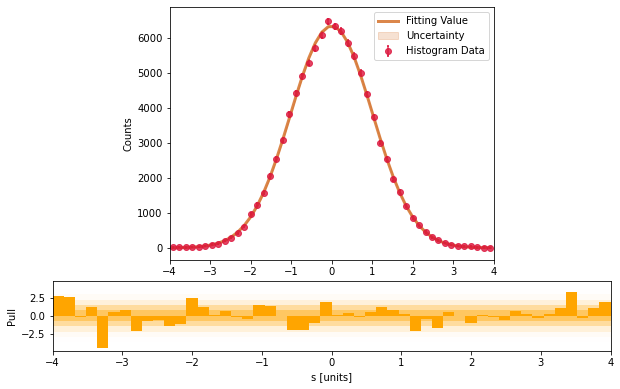

In [13]:
fig = plt.figure(figsize=(10, 8))
grid = fig.add_gridspec(5, 5, wspace=0.3, hspace=0.3)
ax = fig.add_subplot(grid[0:3, 1:4])
pull_ax = fig.add_subplot(grid[3:4, :], sharex=ax)

fig, ax, pull_ax = h.project("S").plot_pull(pdf, fig, ax, pull_ax,\
                                            eb_ecolor='crimson', eb_mfc='crimson',\
                                            eb_mec='crimson', eb_fmt='o', eb_ms=6,\
                                            eb_capsize=1, eb_capthick=2, eb_alpha=.8,\
                                            vp_c='orange', vp_ls='-', vp_lw=2,\
                                            vp_alpha=.8, fp_c='chocolate', fp_ls='-',\
                                            fp_lw=3, fp_alpha=.8, bar_fc='orange',\
                                            pp_num=6, pp_fc='orange', pp_alpha=.618,\
                                            pp_ec=None, ub_alpha=.2
                                           )

ax.set_ylabel("Counts")
pull_ax.set_xlabel(h.axes[0].title)
pull_ax.set_ylabel("Pull")
plt.show()

### Via Mplhep

[mplhep](https://github.com/scikit-hep/mplhep) is an important visualization tools in Scikit-Hep ecosystem. hist has integrate with mplhep and you can also plot using it. If you want more info about mplhep please visit the official repo to see it.

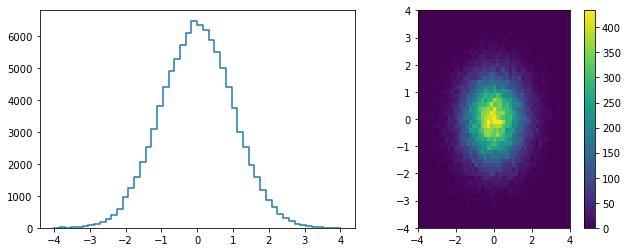

In [14]:
import mplhep

plt.subplot(121)
w, xbins = h.project("S").to_numpy()
mplhep.histplot(w.T, xbins)

plt.subplot(122)
w, xbins, ybins = h.to_numpy()
mplhep.hist2dplot(w.T, xbins, ybins)

plt.show()